# Importamos bibliotecas necesarias

In [1]:
from sys import maxsize #para imprimir arrays completos
import numpy as np
import pandas as pd

from sklearn import preprocessing #para normalizar datos
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns



# Leer el data set desde el archivo csv

In [2]:
pathArchivoDataSet = 'properatti_2.csv'
df = pd.read_csv(pathArchivoDataSet)

In [3]:
df.head(5)

,property_type,place_name,state_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
0,PH,mataderos,Capital Federal,62000.0,40.000000,15.0,1127.272727,2.0,-34.666326,-58.519094,0,0,0,0,0
1,apartment,la plata,Bs.As. G.B.A. Zona Sur,150000.0,69.891566,0.0,2146.181693,3.0,-34.924277,-57.965973,0,1,1,0,0
2,apartment,mataderos,Capital Federal,72000.0,55.000000,0.0,1309.090909,2.0,-34.666326,-58.519094,0,0,0,0,0
3,PH,liniers,Capital Federal,95000.0,92.565511,0.0,1026.300175,3.0,-34.643508,-58.516984,0,0,0,0,0
4,apartment,centro,Buenos Aires Costa Atlántica,64000.0,35.000000,0.0,1828.571429,4.0,-38.000247,-57.547260,0,0,0,0,0


# Definimos el subset de datos del cual generaremos el modelo

### Nos quedamos con el subset de datos relacionados a Capital Federal

In [4]:
filtroParaElSubsetDeDatos = "Capital Federal"

In [5]:
df_subset = df[df['state_name'] == filtroParaElSubsetDeDatos]

In [6]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28666 entries, 0 to 109291
Data columns (total 15 columns):
property_type                28666 non-null object
place_name                   28666 non-null object
state_name                   28666 non-null object
price                        28666 non-null float64
surface_covered_in_m2        28666 non-null float64
surface_not_covered_in_m2    28666 non-null float64
price_usd_per_m2             28666 non-null float64
rooms                        28666 non-null float64
lat_mediaPorZona             28666 non-null float64
lon_mediaPorZona             28666 non-null float64
pileta                       28666 non-null int64
cochera                      28666 non-null int64
balcon                       28666 non-null int64
terraza                      28666 non-null int64
parrilla                     28666 non-null int64
dtypes: float64(7), int64(5), object(3)
memory usage: 3.5+ MB


In [7]:
df_subset.head(5)

,property_type,place_name,state_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
0,PH,mataderos,Capital Federal,62000.0,40.000000,15.0,1127.272727,2.0,-34.666326,-58.519094,0,0,0,0,0
2,apartment,mataderos,Capital Federal,72000.0,55.000000,0.0,1309.090909,2.0,-34.666326,-58.519094,0,0,0,0,0
3,PH,liniers,Capital Federal,95000.0,92.565511,0.0,1026.300175,3.0,-34.643508,-58.516984,0,0,0,0,0
7,apartment,belgrano,Capital Federal,138000.0,40.000000,5.0,3066.666667,1.0,-34.563566,-58.453991,0,0,0,0,0
8,apartment,belgrano,Capital Federal,195000.0,60.000000,5.0,3000.000000,2.0,-34.563566,-58.453991,0,0,0,0,0


# Dropeamos la columna state_name, ya que todos los datos tiene el mismo valor

In [8]:
df_subset = df_subset.drop(labels='state_name', axis = 1)

# Analizamos las variables categóricas

palermo                2682
belgrano               2590
recoleta               2464
caballito              2054
villa urquiza          1358
flores                 1250
balvanera              1189
villa crespo           1176
almagro                1010
capital federal         964
san telmo               958
boedo                   835
nuñez                   687
san cristobal           594
puerto madero           568
san nicolás             494
saavedra                486
floresta                454
villa del parque        449
palermo hollywood       443
monserrat               416
mataderos               404
villa devoto            398
villa luro              396
barracas                396
liniers                 377
colegiales              327
parque patricios        313
palermo soho            300
retiro                  240
coghlan                 227
palermo chico           220
chacarita               205
constitución            199
villa lugano            184
boca                

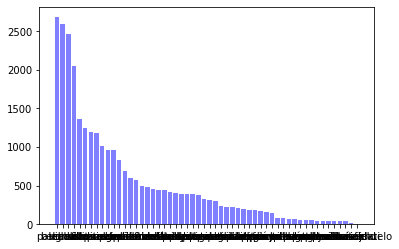

apartment    23656
house         2022
PH            1747
store         1241
Name: property_type, dtype: int64


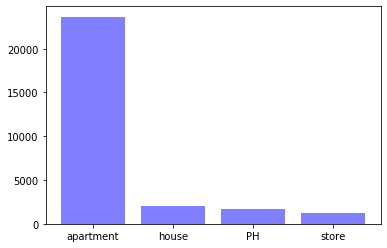

In [9]:
categories = ['place_name', 'property_type']

for category in categories:
    print(df_subset[category].value_counts())
    plt.bar(df_subset[category].value_counts().index, df_subset[category].value_counts().values, color='b',\
            alpha=0.5)
    plt.show()

### Creamos variables dummies a partir de la variable categorica

In [10]:
for category in categories:
    serie = df_subset[category]
    dummies = pd.get_dummies(serie, drop_first= True, prefix=category)
    df_subset = pd.concat([df_subset, dummies], axis=1)

df_subset.head()

,property_type,place_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,...,place_name_villa ortuzar,place_name_villa pueyrredón,place_name_villa real,place_name_villa riachuelo,place_name_villa santa rita,place_name_villa soldati,place_name_villa urquiza,property_type_apartment,property_type_house,property_type_store
0,PH,mataderos,62000.0,40.000000,15.0,1127.272727,2.0,-34.666326,-58.519094,0,...,0,0,0,0,0,0,0,0,0,0
2,apartment,mataderos,72000.0,55.000000,0.0,1309.090909,2.0,-34.666326,-58.519094,0,...,0,0,0,0,0,0,0,1,0,0
3,PH,liniers,95000.0,92.565511,0.0,1026.300175,3.0,-34.643508,-58.516984,0,...,0,0,0,0,0,0,0,0,0,0
7,apartment,belgrano,138000.0,40.000000,5.0,3066.666667,1.0,-34.563566,-58.453991,0,...,0,0,0,0,0,0,0,1,0,0
8,apartment,belgrano,195000.0,60.000000,5.0,3000.000000,2.0,-34.563566,-58.453991,0,...,0,0,0,0,0,0,0,1,0,0


# Guardamos un data frame auxiliar con la relacion entre los dummies y el dato place_name

### Data frame auxiliar para place name

In [11]:
filter_col = [col for col in df_subset if col.startswith('place_name')]
filter_col

['place_name',
 'place_name_almagro',
 'place_name_balvanera',
 'place_name_barracas',
 'place_name_belgrano',
 'place_name_boca',
 'place_name_boedo',
 'place_name_caballito',
 'place_name_capital federal',
 'place_name_chacarita',
 'place_name_coghlan',
 'place_name_colegiales',
 'place_name_constitución',
 'place_name_flores',
 'place_name_floresta',
 'place_name_liniers',
 'place_name_mataderos',
 'place_name_monserrat',
 'place_name_monte castro',
 'place_name_nueva pompeya',
 'place_name_nuñez',
 'place_name_palermo',
 'place_name_palermo chico',
 'place_name_palermo hollywood',
 'place_name_palermo soho',
 'place_name_palermo viejo',
 'place_name_parque avellaneda',
 'place_name_parque centenario',
 'place_name_parque chacabuco',
 'place_name_parque chas',
 'place_name_parque patricios',
 'place_name_paternal',
 'place_name_puerto madero',
 'place_name_recoleta',
 'place_name_retiro',
 'place_name_saavedra',
 'place_name_san cristobal',
 'place_name_san nicolás',
 'place_name_sa

In [12]:
place_name_dummies = df_subset[filter_col]
place_name_dummies = place_name_dummies.loc[:,~place_name_dummies.columns.duplicated()]
place_name_dummies = place_name_dummies.drop_duplicates()
place_name_dummies

,place_name,place_name_almagro,place_name_balvanera,place_name_barracas,place_name_belgrano,place_name_boca,place_name_boedo,place_name_caballito,place_name_capital federal,place_name_chacarita,...,place_name_villa general mitre,place_name_villa lugano,place_name_villa luro,place_name_villa ortuzar,place_name_villa pueyrredón,place_name_villa real,place_name_villa riachuelo,place_name_villa santa rita,place_name_villa soldati,place_name_villa urquiza
0,mataderos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,liniers,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,belgrano,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,palermo soho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,palermo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,flores,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34,boedo,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46,puerto madero,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47,balvanera,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50,caballito,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data frame auxiliar para property_type

In [13]:
filter_col = [col for col in df_subset if col.startswith('property_type')]
filter_col

['property_type',
 'property_type_apartment',
 'property_type_house',
 'property_type_store']

In [14]:
proeprty_type_dummies = df_subset[filter_col]
proeprty_type_dummies = proeprty_type_dummies.loc[:,~proeprty_type_dummies.columns.duplicated()]
proeprty_type_dummies = proeprty_type_dummies.drop_duplicates()
proeprty_type_dummies

,property_type,property_type_apartment,property_type_house,property_type_store
0,PH,0,0,0
2,apartment,1,0,0
46,house,0,1,0
55,store,0,0,1


# Vemos que hay mucha diferencia entre las unidades del precio con la de la superficie y el precio por m2, normalizamos estos valores 

In [15]:
df_subset.head(5)

,property_type,place_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,...,place_name_villa ortuzar,place_name_villa pueyrredón,place_name_villa real,place_name_villa riachuelo,place_name_villa santa rita,place_name_villa soldati,place_name_villa urquiza,property_type_apartment,property_type_house,property_type_store
0,PH,mataderos,62000.0,40.000000,15.0,1127.272727,2.0,-34.666326,-58.519094,0,...,0,0,0,0,0,0,0,0,0,0
2,apartment,mataderos,72000.0,55.000000,0.0,1309.090909,2.0,-34.666326,-58.519094,0,...,0,0,0,0,0,0,0,1,0,0
3,PH,liniers,95000.0,92.565511,0.0,1026.300175,3.0,-34.643508,-58.516984,0,...,0,0,0,0,0,0,0,0,0,0
7,apartment,belgrano,138000.0,40.000000,5.0,3066.666667,1.0,-34.563566,-58.453991,0,...,0,0,0,0,0,0,0,1,0,0
8,apartment,belgrano,195000.0,60.000000,5.0,3000.000000,2.0,-34.563566,-58.453991,0,...,0,0,0,0,0,0,0,1,0,0


# Generamos el objeto para el K Fold

In [37]:
#generamos un K Fold de 5 pasos para el entrenamiento de los modelos
cv = KFold(5, shuffle=True, random_state=10)

# Generamos un modelo con Regresion Lineal

In [38]:
df_model_columns = df_subset.drop(labels= ["price", "property_type", "place_name"], axis=1)
df_model_columns

,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,...,place_name_villa ortuzar,place_name_villa pueyrredón,place_name_villa real,place_name_villa riachuelo,place_name_villa santa rita,place_name_villa soldati,place_name_villa urquiza,property_type_apartment,property_type_house,property_type_store
0,40.000000,15.0,1127.272727,2.0,-34.666326,-58.519094,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,55.000000,0.0,1309.090909,2.0,-34.666326,-58.519094,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,92.565511,0.0,1026.300175,3.0,-34.643508,-58.516984,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40.000000,5.0,3066.666667,1.0,-34.563566,-58.453991,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,60.000000,5.0,3000.000000,2.0,-34.563566,-58.453991,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28661,65.000000,26.0,1813.186813,4.0,-34.592516,-58.397354,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
28662,39.000000,5.0,3750.000000,1.0,-34.592516,-58.397354,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
28663,157.000000,0.0,999.044328,3.0,-34.563566,-58.453991,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
28664,93.000000,20.0,7699.115044,4.0,-34.563566,-58.453991,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0


In [39]:
#definimos como variables para entrenamiento todas las del data frame excepto el precio por m2
#el valor precio por m2 será lo que el modelo intente calcular
X = df_model_columns.drop('price_usd_per_m2', axis=1)
y = df_model_columns['price_usd_per_m2']

In [40]:
#seleccionamos un tamaño para el set de test del 25% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [41]:
regresionLineal = LinearRegression()

### Normalizamos los valores de X

##### Usando sklearn L1

In [52]:
X_train.head(1)

,surface_covered_in_m2,surface_not_covered_in_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla,...,place_name_villa ortuzar,place_name_villa pueyrredón,place_name_villa real,place_name_villa riachuelo,place_name_villa santa rita,place_name_villa soldati,place_name_villa urquiza,property_type_apartment,property_type_house,property_type_store
26282,110.0,27.431323,4.0,-34.551392,-58.483124,0,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0


In [53]:
X_train_norm_l1 = preprocessing.normalize(X_train, norm='l1', axis=0)

In [54]:
X_train_norm_l1

array([[7.69334221e-05, 1.65256796e-04, 7.06713781e-05, ...,
        5.63158191e-05, 0.00000000e+00, 0.00000000e+00],
       [5.45527902e-05, 0.00000000e+00, 3.53356890e-05, ...,
        5.63158191e-05, 0.00000000e+00, 0.00000000e+00],
       [2.30800266e-05, 0.00000000e+00, 1.76678445e-05, ...,
        5.63158191e-05, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.89576323e-05, 0.00000000e+00, 5.30035336e-05, ...,
        5.63158191e-05, 0.00000000e+00, 0.00000000e+00],
       [4.92931118e-05, 0.00000000e+00, 8.83392226e-05, ...,
        5.63158191e-05, 0.00000000e+00, 0.00000000e+00],
       [2.44788161e-05, 3.50410702e-05, 1.76678445e-05, ...,
        5.63158191e-05, 0.00000000e+00, 0.00000000e+00]])

##### Usando sklearn L2

In [55]:
X_train_norm_l2 = preprocessing.normalize(X_train, norm='l2', axis=0)

In [56]:
X_train_norm_l2

array([[0.00999811, 0.01277633, 0.00907242, ..., 0.00750439, 0.        ,
        0.        ],
       [0.00708957, 0.        , 0.00453621, ..., 0.00750439, 0.        ,
        0.        ],
       [0.00299943, 0.        , 0.0022681 , ..., 0.00750439, 0.        ,
        0.        ],
       ...,
       [0.00636243, 0.        , 0.00680431, ..., 0.00750439, 0.        ,
        0.        ],
       [0.00640603, 0.        , 0.01134052, ..., 0.00750439, 0.        ,
        0.        ],
       [0.00318122, 0.00270909, 0.0022681 , ..., 0.00750439, 0.        ,
        0.        ]])

In [70]:
X_test_norm_l2 = preprocessing.normalize(X_test, norm='l2', axis=0)

##### Seleccionamos la normalizacion L2

### Generamos un data frame auxiliar con los valores normalizados

In [64]:
X_train_normalizado = pd.DataFrame(X_train_norm_l2, columns = X_train.columns)

In [65]:
X_train_normalizado.head(5)

,surface_covered_in_m2,surface_not_covered_in_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla,...,place_name_villa ortuzar,place_name_villa pueyrredón,place_name_villa real,place_name_villa riachuelo,place_name_villa santa rita,place_name_villa soldati,place_name_villa urquiza,property_type_apartment,property_type_house,property_type_store
0,0.009998,0.012776,0.009072,-0.006810,-0.006826,0.00000,0.012096,0.011545,0.012999,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007504,0.000000,0.0
1,0.007090,0.000000,0.004536,-0.006827,-0.006828,0.00000,0.012096,0.011545,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007504,0.000000,0.0
2,0.002999,0.000000,0.002268,-0.006824,-0.006816,0.00000,0.000000,0.011545,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007504,0.000000,0.0
3,0.009484,0.000000,0.009072,-0.006821,-0.006826,0.00000,0.012096,0.011545,0.012999,0.019017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.025658,0.0
4,0.002727,0.002329,0.002268,-0.006825,-0.006818,0.01708,0.000000,0.011545,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007504,0.000000,0.0


In [72]:
X_test_normalizado = pd.DataFrame(X_test_norm_l2, columns = X_test.columns)

##### Ahora calculamos el modelo de la Regresion Lineal

In [82]:
# se pueden usar otros scores: MSE, etc, para explicar mejor las decisiones
#el R2 puede ser muy tecnico
#para explicar los errores que obtenemos

#verificar tambien los siguientes metodos
#cross_val_predict (ver documentacion)
#cross_validate
regresionLineal_scores = cross_val_score(regresionLineal, X_train_normalizado, y_train, cv=cv, scoring='neg_mean_squared_error')

regresionLineal_scores, regresionLineal_scores.mean()

(array([-11653625.71053426,  -5883660.02444181, -15009242.09698167,
         -5659478.79844955,  -7406594.63764788]), -9122520.253611034)

### Realizamos un entrenamiento de una sola pasada, para ver que nos devuelve

In [73]:
regresionLineal_model = regresionLineal.fit(X_train_normalizado, y_train)

In [74]:
print('Score model_1:', regresionLineal_model.score(X_test_normalizado, y_test))

Score model_1: -1.6408315126831685e+22


In [69]:
#ver que features tiene mas peso en el modelo, de acuerdo a los resultados de coeficientes
regresionLineal_model.coef_

array([-9.66136484e+04, -4.44932350e+04,  1.23394679e+04,  6.30325561e+16,
        1.24328882e+16,  4.76094401e+02,  7.40235122e+03, -6.67833614e+03,
       -3.88471974e+03,  6.68030000e+04,  2.70701284e+12,  3.17399265e+12,
        6.97008782e+12, -1.80663717e+13,  3.82324734e+12,  7.83560508e+12,
        1.02391541e+13,  6.74946357e+12, -1.24881643e+12, -4.91001605e+12,
       -3.45158206e+12,  2.03401620e+13,  1.27365738e+13,  8.78646781e+12,
        1.14988109e+13,  1.69269973e+13,  2.35926522e+12,  2.97446515e+12,
        2.27597199e+13, -1.31924684e+13, -9.72527382e+12, -3.65917837e+12,
       -3.82491862e+12, -1.88502985e+12, -5.52491189e+11,  4.21803441e+12,
        6.02300701e+11,  4.83852476e+12, -4.77649909e+11,  6.36357894e+12,
        1.23715232e+12,  1.77018018e+12, -5.62929990e+12, -1.54219250e+12,
       -9.89359891e+12,  5.26387680e+12, -5.16725436e+10,  5.15825288e+12,
        2.50264120e+12,  3.37910276e+12, -9.11114149e+10,  3.27642281e+12,
        2.85083143e+12,  

# Generamos el modelo para Ridge Cross Validation

In [ ]:
#para el RidgeCV elegimos un alpha desde 0.1 hasta 1, con 300 muestras entre esos dos valores

lm_ridge = RidgeCV(alphas=np.linspace(0.1,1,300), normalize=False, cv=cv) 
# Definimos el rango de de búsqueda del hiperparametro explicitamente

model_2 = lm_ridge.fit(X_train, y_train)

#ver cual es el alpha que eligio


print('Score model_2:', model_2.score(X_test, y_test))


In [ ]:
model_2.alpha_

# Generamos el modelo para Lasso Cross Validation

In [ ]:
#para este modelo elegimos un alpha desde 0.1 hasta 1, con 300 muestras entre esos dos valores 
lm_lasso = LassoCV(alphas=np.linspace(0.1,1,300), normalize=False, cv=cv)
model_3 = lm_lasso.fit(X_train, y_train)
print('Score model_3:', model_3.score(X_train, y_train))


In [ ]:
#ejecutamos el LassoCV, usando el cross validation definido anteriormente con 5 iteraciones
model = LassoCV().fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum())

In [ ]:
model.intercept_

In [ ]:
model.coef_

In [ ]:
#de los 3 modelos analizar el mejor
#con ridge y lasso, analizar con que coeficientes se queda